# 准备工作
## \* Google Colab 部署使用

利用Google Colab可获取12GB RAM和8G GPU运算资源，减轻本地计算机负担。由于Colab是在服务器虚拟机上运行，不能和本地文件相连，因此需要将数据文件上传。而由于Colab的不稳定性，虚拟机在用户退出使用或遭到意外时会立即销毁，因此需要将文件上传到谷歌硬盘而非虚拟机。接下来的操作可以**让虚拟机在运行时连接到自己的谷歌硬盘**。

如果您是在本地计算机运行程序，请**不要运行**接下来的代码块。



In [ ]:
from google.colab import drive
drive.mount('/content/drive')  #连接到谷歌硬盘，会弹出一个链接，点击链接
                #并登录您的谷歌账号后，系统将提供一个密码，
                #复制到输入框内即可通过验证。

import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/Projects/Text Classifier/DeepLearningTrain')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projects/TextMining/Text_Classifier1')
# 设定项目默认目录，默认My Drive下是谷歌硬盘根目录，根据实际情况配置。

# 接下来就可以使用相对地址了

Mounted at /content/drive


## 导入本次项目需要用到的包

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import sklearn
import string
import random
import matplotlib.pyplot as plt
import re

# 数据读取与预处理

## 文本字符串清洗处理

## 从sqlite3数据库文件读取数据

## 句子分割

使用神经网络进行深度学习时，要求输入的张量必须具有相同的维度，这对张量形状提出了要求。

根据我们先前对文本的总体把握，现代文文本语篇的平均长度要明显大于诗词等，如果本次实验还将语篇作为单个分类的对象，那么对于较短的语料其张量会存在着大量的空标签，造成影响很大的冗余，会大幅降低准确度，提升损失值，同时张量长度的增大也会造成计算的缓慢。因此我们需要转换策略，减少分类文本在字符长度上的悬殊。

我们决定使用句号`。`来切分文本，根据调研，调取各6000条语料，使用句号分割可以获得约25万条句子，而限定长度为40可以获得约23万条句子，较为合理，因此限定长度为40.

In [ ]:
def load_from_db(num,start):
    conn = sqlite3.connect("data/database/texts.db")
    # conn = sqlite3.connect("data/texts.db")
    print ('Opened database successfully')
    c = conn.cursor()
    # 数据表结构(id,texts,type,sourceid)
    ci_data=[]
    cursor = c.execute("SELECT * from ci order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        ci_data.append(row)

    poet_data = []
    cursor=c.execute("SELECT * FROM poet order by id desc limit "+str(start)+","+str(num))
    for row in cursor:
        poet_data.append(row)

    classical_data = []
    cursor=c.execute("SELECT * FROM classical order by id desc limit "+str(start)+","+str(num//1.35))
    for row in cursor:
        classical_data.append(row)

    journal_data = []
    cursor=c.execute("SELECT * FROM journal order by id desc limit "+str(start)+","+str(num//1.1))
    for row in cursor:
        journal_data.append(row)
    
    news_data = []
    cursor=c.execute("SELECT * FROM news order by id asc limit "+str(start)+","+str(num//1.1))
    for row in cursor:
        news_data.append(row)

    print("所有类型数据读取成功，每类的条数："+str(num))
    conn.close()
    data = ci_data + poet_data + classical_data + journal_data + news_data

    df = pd.DataFrame(data)
    df.rename(columns={0:'id',1:'texts',2:'type',3:'sourceid'},inplace=True)
    # 仅保留text中的字母数字汉字和句号
    df['texts'] = df['texts'].apply(lambda x:re.sub(u"[^a-zA-Z0-9\u4E00-\u9FA5。]","",x))
    df = df.drop(['id','sourceid'],axis=1)
    #expand设为True将分出来的句子单独成列
    sentences = df['texts'].str.split('。',expand=True).stack().reset_index(level=1,drop=True).rename('sentence') 
    df = df.drop(['texts'],axis=1).join(sentences)
    df = df[(df['sentence'].map(len)>7) & (df['sentence'].map(len)<40)]

    return df


In [ ]:
data = load_from_db(20000,0)
display(data[data['type']=='ci'])
display(data[data['type']=='poet'])
display(data[data['type']=='classical'])
display(data[data['type']=='modern'])
# test_data = load_from_db(1000,10000)

Opened database successfully
所有类型数据读取成功，每类的条数：20000


,type,sentence
2,ci,剪新幡儿斜插真珠髻
3,ci,露着桂枝晓霜护菊篱秋
3,ci,无尘玉宇南极一点瑞光浮
3,ci,崧岳精英瑞世河洛图书寓直琳馆奉宸游
3,ci,独袖功名手谁与复神州
...,...,...
19978,ci,皇图大业超前古垂象泰阶平
19978,ci,岁时丰衍九土乐升平
19978,ci,道高尧舜垂衣治日月并文明
19978,ci,嘉禾甘露登歌荐云物焕祥经


,type,sentence
19979,poet,圣祖发神谋灵符叶帝求
19979,poet,一人光锡命万国荷时休
19979,poet,雷解圜丘毕云需曲水游
19979,poet,岸花迎步辇仙仗拥行舟
19979,poet,睿藻天中降恩波海外流
...,...,...
39977,poet,莫怆分飞岐路别还当奏最掖垣来
39978,poet,直省清华接建章向来无事日犹长
39978,poet,花间燕子栖鹊竹下鹓雏绕凤皇
39978,poet,内史通宵承紫诰中人落晚爱红妆


,type,sentence
39979,classical,徐守仁义社稷邱墟
39979,classical,鲁尊儒墨宗庙泯灭
39979,classical,与贵者言依於势贵位高而势制高则位不可以禁势
39979,classical,与富者言依於物富积财而物可宝则财不足以易宝
39979,classical,与贫者言依於利贫匮乏而利丰赡则乏不可以賙丰
...,...,...
54792,classical,司马缩奠俎于羊湆俎南乃载于羊俎卒载俎缩执俎以降
54792,classical,次宾羞羊燔缩执俎缩一燔于俎上盐在右
54792,classical,尸左执爵受燔扌耎于盐坐振祭哜之兴加于羊俎
54792,classical,尸降筵北面于西楹西坐卒爵执爵以兴坐奠爵拜执爵以兴


,type,sentence
54793,modern,2003年卢作孚先生被重庆市民和专家分别评为重庆十大文化名人并均列第一
54793,modern,专家的评语写道民生公司北碚实验区卢作孚文集其中任一项都足以改变世界
54795,modern,这也正是他的独特价值所在
54797,modern,卢作孚留给后人的不仅是他的事业更是他的精神人格力量
54797,modern,如梁漱溟所说他胸怀高旷公而忘私为而不有庶几乎可与古之贤哲媲美
...,...,...
91152,modern,程某继承母业继续贩卖假烟
91152,modern,记者徐其勇实习生郭永强通讯员严义华
91153,modern,图为日多名留守儿童在江滩公园进行放纸飞机比赛
91153,modern,本报视界网邱孝威摄


In [ ]:
texts = data['sentence'].values
labels = data['type'].values
np.random.seed(10)
mix_index = np.random.choice(len(texts),len(texts))
shu_texts = np.array(texts)[mix_index].tolist()
input_labels = np.array(labels)[mix_index].tolist()
labels_one_hot = []
for label in input_labels:
    if label =="modern":
        labels_one_hot.append([1,0,0,0])
        print('\r'+label,end="")
    elif label =="ci":
        labels_one_hot.append([0,0,0,1])
        print('\r'+label,end="")
    elif label =="poet":
        labels_one_hot.append([0,0,1,0])
        print('\r'+label,end="")
    elif label =="classical":
        labels_one_hot.append([0,1,0,0])
        print('\r'+label,end="")


ci

In [ ]:
!pip install pytorch-transformers==1.0

In [ ]:
from pytorch_transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

model_name = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(model_name)
# samples = ['[CLS]中国的首都是位于华北的北京[SEP]']
# tokenized_text = [tokenizer.tokenize(i) for i in samples]
# input_ids = [tokenizer.convert_tokens_to_ids(i) for i in tokenized_text]
# input_ids = torch.LongTensor(input_ids)

tokenized_text = [["[CLS]"]+tokenizer.tokenize(i)+["[SEP]"] for i in shu_texts]
input_ids = [tokenizer.convert_tokens_to_ids(i) for i in tokenized_text]
input_labels = labels_one_hot

# 将样本数据填充至长度为40
for j in range(len(input_ids)):
    i = input_ids[j]
    if len(i) != 43:
        input_ids[j].extend([0]*(43-len(i)))
print(input_ids[:10])
train_ids = input_ids[:len(input_ids)*4//5]
train_labels = input_labels[:len(input_ids)*4//5]

eval_ids = input_ids[len(input_ids)*4//5:]
eval_labels = input_labels[len(input_ids)*4//5:]

train_set = TensorDataset(torch.LongTensor(train_ids),torch.FloatTensor(train_labels))
train_loader = DataLoader(dataset=train_set,batch_size=256,shuffle = False)
eval_set = TensorDataset(torch.LongTensor(eval_ids),torch.FloatTensor(eval_labels))
eval_loader = DataLoader(dataset=eval_set,batch_size=256,shuffle = True)

[[101, 7371, 3635, 1185, 1063, 2358, 4639, 1921, 869, 3174, 804, 1188, 1353, 3176, 1395, 869, 4639, 1370, 672, 3622, 7553, 3953, 3174, 1502, 1921, 2169, 5420, 739, 2348, 6859, 6815, 3153, 1266, 6957, 2145, 2822, 102, 0, 0, 0, 0, 0, 0], [101, 3126, 5473, 3148, 1752, 723, 1410, 3301, 3275, 5991, 1072, 3697, 5443, 1316, 5648, 1071, 5446, 5632, 1072, 1863, 6520, 810, 680, 5413, 1174, 810, 6883, 6122, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2022, 1259, 100, 5659, 100, 4284, 5396, 1578, 801, 1763, 2553, 2420, 3267, 679, 1105, 2553, 2832, 5166, 2111, 740, 1940, 6630, 4685, 6842, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 5727, 4576, 3172, 4404, 2253, 5771, 5683, 2373, 5385, 6171, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2383, 810, 1218, 708, 7558, 3634, 1287, 1083, 2163, 1454, 3342, 5636, 5791, 2769, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 843,

## 模型搭建！

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.nn.functional as F
from pytorch_transformers import BertModel

class fn_cls(nn.Module):
    def __init__(self):
        super(fn_cls,self).__init__()
        self.model = BertModel.from_pretrained(model_name,cache_dir="./")
        self.model.to(device)
        self.dropout = nn.Dropout(0.7)
        self.linear = nn.Linear(768,4)

    def forward(self,x,attention_mask=None):
        outputs = self.model(x,attention_mask=attention_mask)
        x = outputs[1].view(-1,768)
        x = self.dropout(x)
        s = self.linear(x)
        del x
        return s

In [ ]:
from torch import optim

cls = fn_cls()
cls.to(device)
cls.train()

criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()
optimizer = optim.Adam(cls.parameters(),lr = 5e-5)
# optimizer = torch.optim.Adam(cls.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6, amsgrad=False)

def predict(logits):
    res = torch.argmax(logits,1)
    return res

清理内存专用

删除不必要的变量，随后调用empty_cache清除不被引用的内存

In [ ]:
# del cls
# del output,pred,loss,data,target
# torch.cuda.empty_cache()

In [ ]:
from torch.autograd import Variable
import time
pre = time.time()

history_epoches = []
history_loss = []
history_accu = []
epoch = 10

for i in range(epoch):
    total_loss = 0
    total_accurate_item = 0
    total_trained_item = 0
    for batch_idx, (data,target) in enumerate(train_loader):
        trained_item = len(data)
        total_trained_item += trained_item
        accurate_item = 0
        data, target = Variable(data).to(device), Variable(target).to(device)
        mask = []
        for sample in data:
            mask.append([1 if i!=0 else 0 for i in sample])
        mask = torch.Tensor(mask).to(device)
        output = cls(data, attention_mask=None)
        pred = predict(output)
        loss = criterion(sigmoid(output).view(-1,4),target)
        accurate_item = (predict(output) == predict(target)).sum().item()
        total_loss += loss
        total_accurate_item += accurate_item
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        print('\rTime Spent:{:.2f}s___Epoch{}/{} Batch{}/{}.Loss:{} Accuracy:{}'.
              format(time.time()-pre,i+1,epoch,batch_idx+1,len(train_loader),loss,accurate_item/trained_item),end="")
        total_loss += loss.item()
        del output,pred,loss,data,target
        torch.cuda.empty_cache()
    print("\n")
    epoch_loss = total_loss/total_trained_item
    epoch_accu = total_accurate_item/total_trained_item
    history_epoches.append(i+1)
    history_loss.append(epoch_loss)
    history_accu.append(epoch_accu)

print("训练时间",time.time()-pre)

Time Spent:2854.04s___Epoch1/5 Batch1261/1261.Loss:0.11087986081838608 Accuracy:0.9054054054054054

Time Spent:5701.49s___Epoch2/5 Batch1261/1261.Loss:0.08844756335020065 Accuracy:0.9256756756756757

Time Spent:8546.47s___Epoch3/5 Batch1261/1261.Loss:0.04042982682585716 Accuracy:0.9662162162162162

Time Spent:11385.93s___Epoch4/5 Batch1261/1261.Loss:0.06600235402584076 Accuracy:0.9459459459459459

Time Spent:14225.23s___Epoch5/5 Batch1261/1261.Loss:0.03374437987804413 Accuracy:0.9797297297297297

训练时间 14225.512427091599


In [ ]:
correct = 0
total = 0

#test_loss = []
test_accu = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(eval_loader):
        data = data.to(device)
        target = target.long().to(device)

        mask = []
        for sample in data:
            mask.append([1 if i != 0 else 0 for i in sample])
        mask = torch.Tensor(mask).to(device)

        output = cls(data,attention_mask=None)
        pred = predict(output)
        #loss = criterion(sigmoid(output).view(-1,4),target)
        target_p = predict(target)
        # print(pred)
        # print(target_p)
        correct += (pred == target_p).sum().item()
        total += len(data)

        #test_loss.append(loss)
        test_accu.append(correct/total)
    print("Accuracy:{}".format(correct/total))

Accuracy:0.9533200292524512


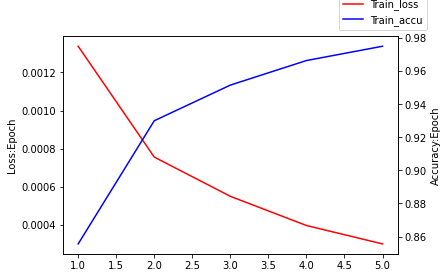

In [ ]:
%matplotlib inline

def plot_history(epoch,loss,accuracy,title):
    x = epoch
    y1 = loss
    y2 = accuracy
    fig,ax1 = plt.subplots()
    ax1.plot(x,y1,'r',label=title+'_loss')
    ax1.set_ylabel('Loss:Epoch')
    ax2 = ax1.twinx()
    ax2.plot(x,y2,'b',label=title+'_accu')
    ax2.set_ylabel('Accuracy:Epoch')
    ax2.set_xlabel('Epoches')
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.show()
plot_history(history_epoches,history_loss,history_accu,title='Train')
# plot_history(history_epoches,test_loss,test_accu,title='Test')

In [ ]:
# def classify(text):
#   #a = get_indices([text])
#   xy = model.predict(torch.tensor(text).to(device))
#   result = xy.cpu().numpy()[0]
#   #modern ci poet classical
#   typedict={0:"现代文",1:"词",2:"诗",3:"文言文"}
#   return typedict[result]

# print(classify("武汉大学位于武汉市武昌区珞珈山街道，是一所高水平一流大学"))
# print(classify("枯藤老树昏鸦，小桥流水人家，古道西风瘦马，夕阳西下，断肠人在天涯"))
# print(classify("晋太元中，武陵人捕鱼为业，沿溪行，忘路之远近，忽逢桃花林"))